<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/Bursty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Denote the gene expression matrix by $X_{ij}$ where j is gene index and i is cell index. In summary, we assume a specific model of transcription and want to solve**

\begin{align}
    & \text{argmax}_{\theta_j} \sum_{j} \sum_i \ln P(\mathcal{X}_{ij},t_i; \theta_j,\tau).
\end{align}

We assume t follows a uniform distribution on [0,1]. We use alternative minimization/EM-like algorithm to find optimal θ.

In [2]:
import numpy.matlib
import scipy
from scipy.stats import poisson, nbinom
import time
import matplotlib.pyplot as plt

In [66]:
a=np.array([1,4,6])
a[-3:]

array([1, 4, 6])

## Get 2D PMF

In [84]:
# -*- coding: utf-8 -*-

# Scientific computing imports
import numpy as np
from numpy.fft import irfftn

def get_P(theta, t_array, tau, mx):
    ## theta = a_1,..., b, u0, s0, beta, gamma
    ##
    ## outline:
    ##   get u and flatten it => u 
    ##   use cumtrapz to integrate phi which has shape (len(t), mx[0]*(mx[1]//2+1) )
    ##   generating function gf=np.exp(phi)
    ##   use irfftn(gf) to get P which has shape(len(t), mx[0], mx[1])

    K = len(tau)-1
    if len(theta)!=2*K+4:
      raise ValueError("check theta")
    kvec = np.array(theta[0:K])
    bvec = np.array(theta[K:-4])
    u0,s0,beta,gamma = theta[-4:]
    
    ## Get generating function argument u
    us = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        us.append(u_)
    u = np.meshgrid(*[u_ for u_ in us], indexing='ij')
    for i in range(len(mx)):
        u[i] = u[i].flatten()

    ## Get generating function
    ## M(u)=1/(1 - bu)
    ## phi = int_0^t k*bU/(1-bU) + phi_0
    ## q = bU 
   
    c0 = (u[0]) - (beta/(beta - gamma))*(u[1])       #  coef of e^{-beta s}
    c1 = (beta/(beta - gamma))*(u[1])   # coef of e^{-gamma s}

    
    # get k(T-t) k_array[i] = k(T - t_array[i])
    t_array = np.reshape(t_array,(-1,1))
    k_array=np.ones_like(t_array)*kvec[0]
    b_array=np.ones_like(t_array)*bvec[0]
    for k in range(1,K):
      idx = tau[k]<(t_array[-1]-t_array)
      k_array[idx] = k_array[idx] + kvec[k] - kvec[k-1]
      b_array[idx] = b_array[idx] + bvec[k] - bvec[k-1]

    c0 = c0.reshape((1,-1))
    c1 = c1.reshape((1,-1)) 
    
    phi = np.zeros((len(t_array),len(u[0])), dtype=np.complex64)    # initialize array to store ODE  
    U = c0*np.exp(-beta*t_array) + c1*np.exp(-gamma*t_array)    
    for i in range(2,len(t_array)+1):       
      q = b_array[-i:]*U[:i,:]
      integrand = k_array[-i:]*q/(1-q)
      integral = np.trapz(y=integrand, x=t_array[:i], axis=0)     # integrate ODE solution                   
      phi[i-1,:] = integral

    gf = np.exp(phi)               # get generating function
    gf = gf.reshape((len(tvec),half[0],half[1])) 
    P = irfftn(gf, s=mx)
    return P


def neglogL_bursty(theta, x, weight,t,tau):
    """
    calculte negative log likelihood for n data points of one gene
    theta: length K+5: a_1, ..., a_K, u0, s0, beta, gamma, b
    x: n*2 expression of one gene
    weight: n*m
    t: len m
    tau: len K+1
    return a scaler
    """

    P=get_P  # P: m*mx[0]*mx[1]
    L=P[:,:,x] #n
    logL = np.sum(weight * np.log(L))
    return -logL

## Gillespie

In [4]:
from math import log, exp

### 2d

In [5]:
def Gillespie_bursty_2D_single(ts, te, x0, kvec, tau, beta, gamma, bvec, random_seed = 42):
    """
    Gillespie algorithm for the system:
        null -> X1: production rate
        X1 -> X2 : beta
        X2 -> null: degradation rate gamma
     
    Parameters
    ----------
    ts : float
        Start time 
    te : float
        End time 
    x0 : 1D array
        Initial value
    beta : float
        Splicing rate
    gamma: float
        Degradation rate 
    bs : floats
        mean burst size
    random_seed : int
        set numpy.random.seed
        
    Returns
    -------
    T : ndarray
        Time points  
    X : ndarray
        The value of x at time points in T

    """
    # np.random.seed is global
    if isinstance(random_seed, int):
        np.random.seed(random_seed)

    #np.random.seed()    
    t=ts
    x=x0.copy() #system state
    T=[]
    X=[]

    while t<te:

        T.append(t)
        X.append(x.copy()) # have to use copy!!! 
        r1,r2=np.random.uniform(0,1,2) 
        
        # calculate propensity functions
        state = np.sum(np.array(tau)<=t)-1
        k = kvec[state]
        b = bvec[state]
        a_cumsum=np.array([k, beta*x[0]+k, gamma*x[1]+beta*x[0]+k])
        wait_time=-log(r1)/a_cumsum[-1]
            
        t=t+wait_time
        
        a_normalized=a_cumsum/a_cumsum[-1]
        if r2<= a_normalized[0]:
            x[0]=x[0]+np.random.geometric(1/(b+1))-1
        elif r2<= a_normalized[1]:
            x=x+np.array([-1,1])
        else:
            x=x+np.array([0,-1])

    T.append(t)
    X.append(x)

    return np.array(T), np.array(X)

In [6]:
def Gillespie_bursty_2D(ncell, tvec, x0, kvec, tau, beta, gamma, bvec, random_seed = None):
    m = len(tvec)
    X = np.zeros((ncell,m,2))
    for i in range(ncell):
        T, x = Gillespie_bursty_2D_single(tvec[0], tvec[-1], x0, kvec, tau, beta, gamma, bvec, random_seed)
        k=0
        for j in range(m):
            while T[k]<=tvec[j]:
                k=k+1
            X[i,j,:]=x[k-1]
    return X

## Inhomogeneous burst size

### Functions

In [86]:
def gillvec_burst_inhom(k,tvec,tau,bvec,S,nCells,propfun,burstfun):
    n_species = S.shape[1]

    num_t_pts = len(tvec)
    X_mesh = np.zeros((nCells,num_t_pts,n_species),dtype=int) #change to float if storing floats!!!!!!! 

    t = np.zeros(nCells,dtype=float)
    tindex = np.zeros(nCells,dtype=int)

    #initialize state: integer unspliced, integer spliced 
    X = np.zeros((nCells,n_species),dtype=int)

    #initialize list of cells that are being simulated
    activecells = np.ones(nCells,dtype=bool)
    while any(activecells):
        mu = np.zeros(nCells,dtype=int)
        n_active_cells = np.sum(activecells)        
        (dt,mu_upd) = rxn_calculator(X[activecells,:],k,propfun)

        t[activecells] += dt
        mu[activecells] = mu_upd

        update = np.zeros(nCells,dtype=bool)
        update[activecells] = t[activecells] > tvec[tindex[activecells]]
        while np.any(update):
            X_mesh[update,tindex[update],:] = X[update]
            tindex += update
            ended_in_update = (tindex==num_t_pts) #less efficient
            if np.any(ended_in_update):
                activecells[ended_in_update] = False
                mu[ended_in_update] = 0
                if not np.any(activecells):
                    print('end simulation')
                    break
            update = np.zeros(nCells,dtype=bool)
            update[activecells] = t[activecells]>tvec[tindex[activecells]]
        
        burst = (mu == 1) & activecells
        bs = burstfun(tau,bvec,t[burst])
        # print(bs.shape)
        bsrand = (np.random.geometric(1/(1+bs))-1 )
        # print(bsrand.shape)
        X[burst] += bsrand[:,None]
        X[~burst] += S[mu[~burst]-1]
    return X_mesh

def rxn_calculator(X,k,propfun):
    nRxn = len(k)
    nCells = X.shape[0]

    a = np.zeros((nCells,nRxn),dtype=float)
 ################################
    a = propfun(a, k, X)
#################################
    a0 = np.sum(a,1)
    dt = np.log(1./np.random.rand(nCells)) / a0
    r2ao = a0 * np.random.rand(nCells)
    mu = np.sum(np.matlib.repmat(r2ao,nRxn+1,1).T >= np.cumsum(np.matlib.hstack((np.zeros((nCells,1)),a)),1) ,1)
    return (dt,mu)

def propfun_bursty(a,k,x):
    # a shape (nCells,nRxn)
    # x shape (nCells,nSpecies)
    k1,beta,gamma = k
    x = x.T
    a = a.T
    #######
    #fill in this part
    a[0] = k1
    a[1] = beta * x[0]
    a[2] = gamma * x[1]
    #######
    a = a.T
    return a


In [87]:
def piecewise_constant(tau,kvec,t):
    # print(type(t))
    # print(t.shape)
    if (isinstance(t,np.ndarray)):
        k = np.zeros(t.shape)
        for i in range(len(t)):
            lowlim = np.where(tau<=t[i])[0][-1]
            k[i] = kvec[lowlim]
        # print(k)//
    elif (isinstance(t,float) or isinstance(t,complex)):
        lowlim = np.where(tau<=t)[0][-1]
        k = kvec[lowlim]
    else:
        print(type(t))
        raise ValueError
    return k

In [88]:
def eval_model_inh_burst_rk(tau,ki,beta,bvec,burstfun,tvec,T,limits):
    mx = limits//2 + 1
    l = np.arange(mx)
    u = np.exp(-2j*np.pi*l/limits)-1
    y0 = np.zeros(u.shape,dtype=np.complex128)
    fun = lambda t,y: ki*(1/(1-burstfun(tau,bvec,T-t)*u*np.exp(-beta*t)) - 1)
    # res = scipy.integrate.solve_ivp(fun,[0,T],y0,t_eval=tvec,method='RK45')
    res = scipy.integrate.solve_ivp(fun,[0,T],y0,t_eval=tvec,method='RK45',rtol=1e-16,atol=1e-200)
    gf = res.y.T

    integral = np.exp(gf)
    Pss = irfftn(integral,s=[limits,])
    return Pss.squeeze()


In [89]:
def eval_model_inh_burst_cheap(tau,ki,beta,bvec,burstfun,tvec,T,limits):
    mx = limits//2 + 1
    l = np.arange(mx)
    u = np.exp(-2j*np.pi*l/limits)-1
    
    integrand = (1/(1-burstfun(tau,bvec,T-tvec)[:,None]*u[None,:]*np.exp(-beta*tvec[:,None])) - 1) 
    integral = np.exp(ki*scipy.integrate.cumtrapz(integrand,x=tvec,axis=0,initial=0))

    Pss = irfftn(integral, s=[limits,]) 
    return Pss.squeeze()

### Test

**Generate data**

In [76]:
S = np.asarray([[10,0],[-1,1],[0,-1]],dtype=int)
k = [10.0,10.0,5.0]

nCells = 10000
T=1

tvec = np.linspace(0,T,1001)
propfun = propfun_bursty

bvec = np.asarray([10,5]).astype(float)
tau = np.asarray([0, 0.5]).astype(float)

burstfun = piecewise_constant

In [77]:
X = gillvec_burst_inhom(k,tvec,tau,bvec,S,nCells,propfun,burstfun)

end simulation


In [95]:
Tau = np.append(tau,T)
X_ = Gillespie_bursty_2D(ncell=nCells, tvec=tvec, x0=np.array([0,0]), kvec=[k[0],k[0]], tau=Tau, beta=k[1], gamma=k[2], bvec=bvec, random_seed = None)

**Get pmf**

In [85]:
mx = [X[:,:,0].max()+10,X[:,:,1].max()+10]
theta = [k[0],k[0],bvec[0],bvec[1],0,0,k[1],k[2]]
Tau = np.append(tau,T)
t1 = time.time()
pmf = get_P(theta, tvec, Tau, mx)
t2 = time.time()
print(t2-t1)

326.34388518333435


In [90]:
t1 = time.time()
pmf1 = eval_model_inh_burst_rk(tau,k[0],k[1],bvec,burstfun,tvec,T,mx[0])
t2 = time.time()
print(t2-t1)
#tau,ki,beta,bvec,burstfun,tvec,T,limits

/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


0.25079917907714844


In [91]:
t1 = time.time()
pmf2 = eval_model_inh_burst_cheap(tau,k[0],k[1],bvec,burstfun,tvec,T,mx[0])
t2 = time.time()
print(t2-t1)

0.03802180290222168


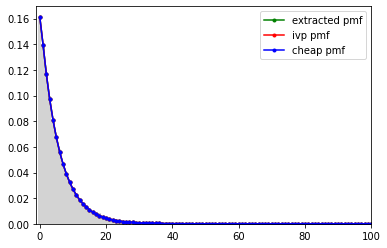

In [92]:
j=-1

bins = np.arange(mx[0])-0.5
_=plt.hist(X[:,j,0],bins=bins,density=True,facecolor='lightgray')

x = np.arange(mx[0])
y = pmf[j].sum(axis=1)
plt.plot(x,y,'g.-',label='extracted pmf')

y = pmf1[j]
plt.plot(x,y,'r.-',label='ivp pmf')

y = pmf2[j]
plt.plot(x,y,'b.-',label='cheap pmf')

#y = scipy.stats.nbinom.pmf(x,k[0]/k[1],1/(1+bvec[-1]))
#plt.plot(x,y,'r.-',label='SS')

plt.legend()
plt.xlim([-1,100]);

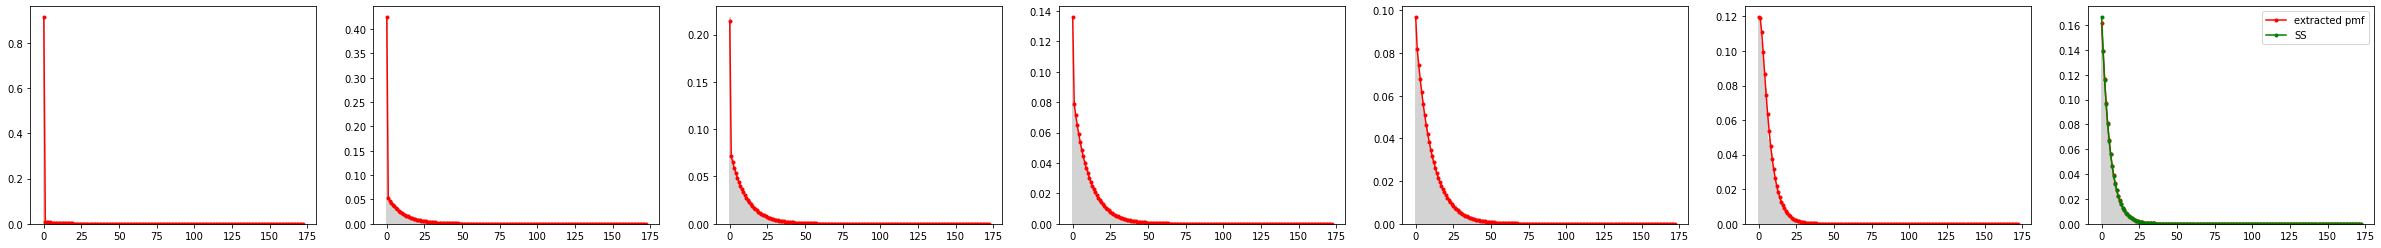

In [93]:
bins = np.arange(mx[0])-0.5
x = np.arange(mx[0])
time_points=[10,100,200,300,500,700,-1]
fig, ax = plt.subplots(1,len(time_points),figsize=(6*len(time_points),4))
for i,j in enumerate(time_points):
    ax[i].hist(X[:,j,0],bins=bins,density=True,facecolor='lightgray')
    y = pmf[j].sum(axis=1)
    ax[i].plot(x,y,'r.-',label='extracted pmf')

y = scipy.stats.nbinom.pmf(x,k[0]/k[1],1/(1+bvec[-1]))
plt.plot(x,y,'g.-',label='SS')

plt.legend();

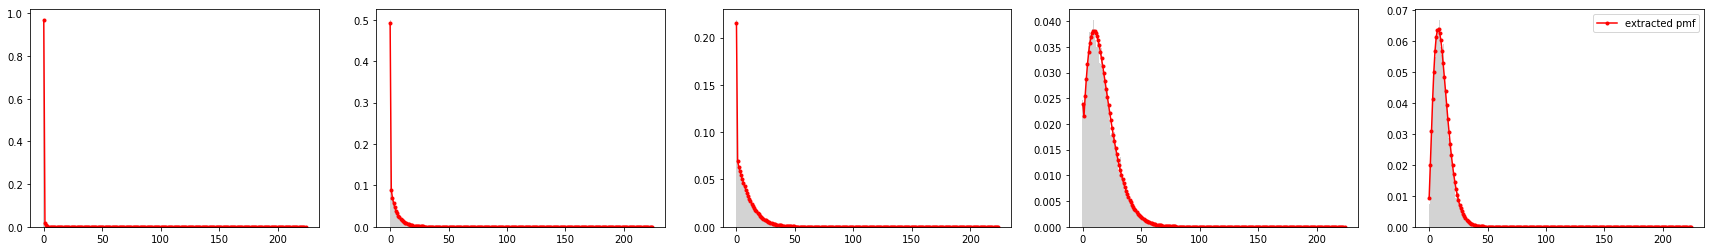

In [96]:
bins = np.arange(mx[1])-0.5
x = np.arange(mx[1])
time_points=[10,100,200,500,1000]
fig, ax = plt.subplots(1,len(time_points),figsize=(6*len(time_points),4))
for i,j in enumerate(time_points):
    ax[i].hist(X_[:,j,1],bins=bins,density=True,facecolor='lightgray')
    y = pmf[j].sum(axis=0)
    ax[i].plot(x,y,'r.-',label='extracted pmf')

plt.legend();
#plt.xlim([-1,100]);

## Inhomogeneous frequency bursty

In [98]:
Tau = [0,0.5,1]
kvec = [10.0, 5.0]
bvec = [10.0, 10.0]
beta, gamma = 10.0, 5.0
nCells = 10000
tvec = np.linspace(0,1,1001)

X = Gillespie_bursty_2D(nCells, tvec, np.array([0,0],dtype=int), kvec, Tau, beta, gamma, bvec)

In [99]:
mx = [X[:,:,0].max().astype(int)+10,X[:,:,1].max().astype(int)+10]
theta = kvec+bvec+[0,0,beta,gamma]

In [100]:
t1 = time.time()
pmf_ = get_P(theta, tvec, Tau, mx)
t2 = time.time()
print(t2-t1)

143.04099369049072


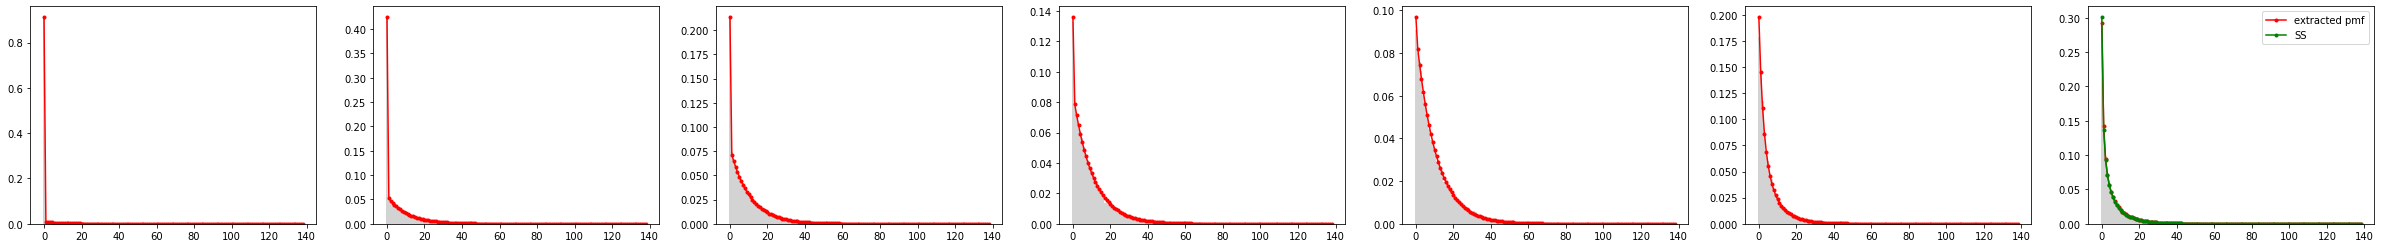

In [102]:
bins = np.arange(mx[0])-0.5
x = np.arange(mx[0])
time_points=[10,100,200,300,500,700,1000]
fig, ax = plt.subplots(1,len(time_points),figsize=(6*len(time_points),4))
for i,j in enumerate(time_points):
    y = pmf_[j].sum(axis=1)
    ax[i].plot(x,y,'r.-',label='extracted pmf')
    ax[i].hist(X[:,j,0],bins=bins,density=True,facecolor='lightgray')

y = scipy.stats.nbinom.pmf(x,kvec[-1]/beta,1/(1+bvec[-1]))
plt.plot(x,y,'g.-',label='SS')

plt.legend();

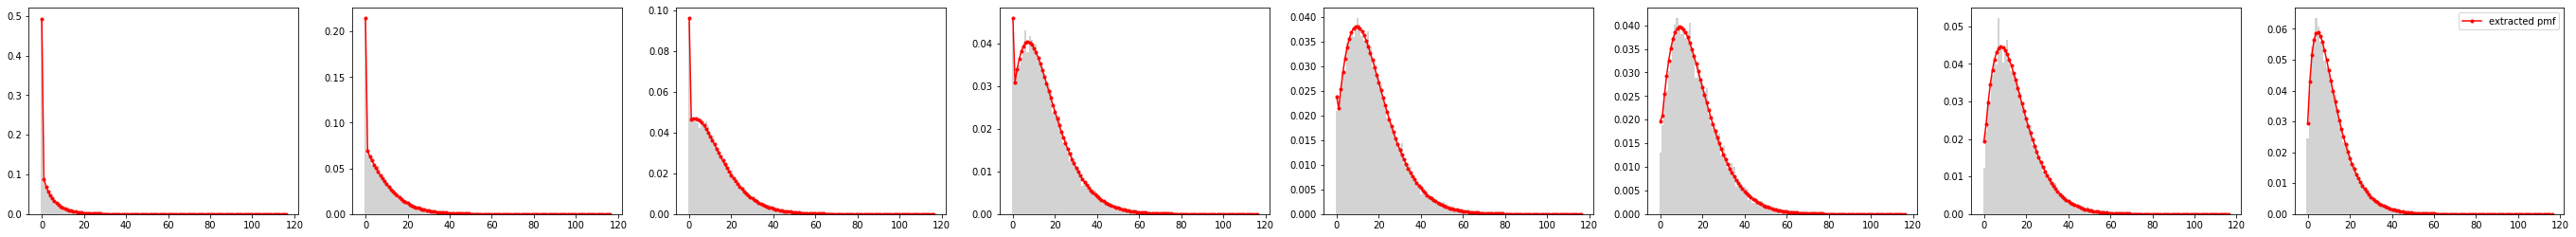

In [105]:
bins = np.arange(mx[1])-0.5
x = np.arange(mx[1])
time_points=[100,200,300,400,500,600,700,1000]
fig, ax = plt.subplots(1,len(time_points),figsize=(6*len(time_points),4))
for i,j in enumerate(time_points):
    ax[i].hist(X[:,j,1],bins=bins,density=True,facecolor='lightgray')
    y = pmf_[j].sum(axis=0)
    ax[i].plot(x,y,'r.-',label='extracted pmf')

plt.legend();
#plt.xlim([-1,100]);